In [ ]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import gammapy_fct as gf
import pandas as pd
import numpy as np
from copy import deepcopy
import astropy
import gammapy
from astropy.table import Table, vstack
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.data import DataStore, EventList
from gammapy.irf.effective_area import EffectiveAreaTable2D
from gammapy.irf.energy_dispersion import EnergyDispersion2D
from gammapy.irf.psf_gauss import EnergyDependentMultiGaussPSF
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs, Background2D

gammapy.data.HDUIndexTable.VALID_HDU_CLASS
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore, Observation
from gammapy.datasets import (
    Dataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff,
    SpectrumDatasetOnOff
)
from gammapy.modeling.models import *
from gammapy.modeling.models import FoVBackgroundModel
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom, Map, RegionNDMap
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    ReflectedRegionsFinder,
    FoVBackgroundMaker
    
)
from astropy.io import fits
from gammapy.estimators import *
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.utils.regions import make_region
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line

/Users/cedrickperron/anaconda3/envs/myenv/lib/python3.11/site-packages/pydantic/_migration.py:282: UserWarning: `pydantic.utils:deep_update` has been removed. We are importing from `pydantic.v1.utils:deep_update` instead.See the migration guide for more details: https://docs.pydantic.dev/latest/migration/
  warnings.warn(


In [2]:
source = "1ES1959"
data_store = DataStore.from_dir(f"/Users/cedrickperron/GAMMAPY/{source}")
hdu_table = data_store.hdu_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/hdu-index.fits.gz")
obs_table = data_store.obs_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/obs-index.fits.gz")
# Changing the path to the fits files in the HDU_table
hdu_table.remove_column("FILE_DIR")
hdu_table.add_column(f"/Users/cedrickperron/GAMMAPY/{source}", name="FILE_DIR")
hdu_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_NAME,HDU_NAME,FILE_DIR
int64,bytes6,bytes10,bytes54,bytes20,str36
37793,events,events,37793.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/1ES1959
37793,gti,gti,37793.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/1ES1959
37793,aeff,aeff_2d,37793.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/1ES1959
37793,edisp,edisp_2d,37793.anasum.fits,ENERGY DISPERSION,/Users/cedrickperron/GAMMAPY/1ES1959
37793,psf,psf_table,37793.anasum.fits,PSF,/Users/cedrickperron/GAMMAPY/1ES1959
37793,bkg,bkg_2d,37793.anasum.fits,BKG,/Users/cedrickperron/GAMMAPY/1ES1959
37890,events,events,37890.anasum.fits,EVENTS,/Users/cedrickperron/GAMMAPY/1ES1959
37890,gti,gti,37890.anasum.fits,GTI,/Users/cedrickperron/GAMMAPY/1ES1959
37890,aeff,aeff_2d,37890.anasum.fits,EFFECTIVE AREA,/Users/cedrickperron/GAMMAPY/1ES1959


In [3]:

data_store.obs_table
data_store.hdu_table = hdu_table

data_store.hdu_table
obs_id = data_store.obs_table["OBS_ID"]



# Note NO HDU of HDU_TYPE = bkg. Write print(hdu_table) and you will see that there is no bkg.
observations = data_store.get_observations(obs_id)
print(len(observations))

110


In [4]:
target_position = SkyCoord(ra="19h59m59.8s",dec="+65d08m55s", frame="icrs")
#print(target_position)-> In (299.99916667, 65.14861111)

on_radius=Angle("0.089 deg")
on_region= CircleSkyRegion(center=target_position,radius=on_radius)

In [8]:
energy_axis = MapAxis.from_energy_bounds(0.350, 15, 10, unit= "TeV", name="energy")


energy_axis_true = MapAxis.from_energy_bounds(0.100, 25, 15, unit= "TeV", name="energy_true")


geom = WcsGeom.create(skydir=target_position, binsz=0.02, width="7 deg", proj="CAR")
geom_image = geom.to_image()
# IS THERE AN EXCLUSION REGION ASIDE FROM THE CENTER???
center_region = CircleSkyRegion(center=target_position, radius=0.35 * u.deg)
exclusion_mask=Map.from_geom(geom_image)
exclusion_mask.data=geom_image.region_mask([center_region], inside=False)
#exclusion_mask.sum_over_axes().plot(add_cbar=True)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fa567cbefd0>)

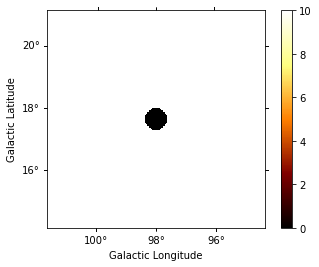

In [9]:

#TODO Take the same exclusion region as Tobias, because you end up with having -600 excess... 
# Exclusion Region 
df=pd.read_csv('./GAMMAPY/exclusion mask.csv', sep=',',header=None)
ra_list = list(df[0])
dec_list = list(df[1])
region_list = []
for ra, dec in zip(ra_list, dec_list):
    region_list.append(make_region(f"icrs;circle({ra}, {dec}, 0.35)"))
exclusion_mask=[]
def exclusion_mask(geom, center_region):
    geom_image = geom
    exclusion_mask=Map.from_geom(geom)
    if center_region not in region_list:
        region_list.append(center_region)
    exclusion_mask.data=geom.region_mask(region_list, inside=False)
    return exclusion_mask

# 0.089
geom = WcsGeom.create(skydir=target_position, binsz=0.02, width="7 deg", frame="galactic", axes=[energy_axis])
center_region = CircleSkyRegion(center=target_position, radius=0.35* u.deg)

exclusion_mask = exclusion_mask(geom, center_region)
exclusion_mask.sum_over_axes().plot(add_cbar=True)

In [10]:
# Dataset Maker
dataset_empty = MapDatasetOnOff.create(geom = geom, energy_axis_true=energy_axis_true, binsz_irf=0.25)

# Contains all the IRFs: aeff is included. No need to specify
dataset_maker = MapDatasetMaker(selection=["counts", "exposure", "edisp", "psf", "background"])
safe_mask_maker = SafeMaskMaker(methods=["aeff-default", "offset-max"], offset_max=1.75*u.deg, aeff_percent=10)

bkg_maker = FoVBackgroundMaker(method="scale", exclusion_mask=exclusion_mask)

In [11]:
%%time
count = 0
list_of_datasets = Datasets()
stacked = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true,binsz_irf=0.25, name=f"stacked")

for ind, obs in enumerate(observations):
    dataset = dataset_maker.run(dataset_empty.copy(name = f"{obs.obs_id}"), obs)
    dataset = safe_mask_maker.run(dataset, obs)
    dataset = bkg_maker.run(dataset, obs)
    #dataset.background = dataset.background * exclusion_mask
    #print(dataset)
    stacked.stack(dataset)
    print(count, dataset)
    list_of_datasets.append(dataset)
    count += 1

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


0 MapDataset
----------

  Name                            : 37793 

  Total counts                    : 1850 
  Total background counts         : 910.83
  Total excess counts             : 939.17

  Predicted counts                : 1828.53
  Predicted background counts     : 1828.53
  Predicted excess counts         : 0.00

  Exposure min                    : 1.57e+03 m2 s
  Exposure max                    : 3.29e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19172.01

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 37793-bkg
    Datasets names            : ['37793']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.008              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


1 MapDataset
----------

  Name                            : 37890 

  Total counts                    : 1628 
  Total background counts         : 781.26
  Total excess counts             : 846.74

  Predicted counts                : 1596.87
  Predicted background counts     : 1596.87
  Predicted excess counts         : 0.00

  Exposure min                    : 2.10e+04 m2 s
  Exposure max                    : 2.46e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 16326.41

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 37890-bkg
    Datasets names            : ['37890']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.044              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


2 MapDataset
----------

  Name                            : 37991 

  Total counts                    : 1013 
  Total background counts         : 781.05
  Total excess counts             : 231.95

  Predicted counts                : 990.70
  Predicted background counts     : 990.70
  Predicted excess counts         : 0.00

  Exposure min                    : 1.71e+02 m2 s
  Exposure max                    : 2.61e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11528.92

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 37991-bkg
    Datasets names            : ['37991']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.268              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


3 MapDataset
----------

  Name                            : 37992 

  Total counts                    : 1084 
  Total background counts         : 910.80
  Total excess counts             : 173.20

  Predicted counts                : 1064.10
  Predicted background counts     : 1064.10
  Predicted excess counts         : 0.00

  Exposure min                    : 1.93e-02 m2 s
  Exposure max                    : 2.79e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12488.54

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 37992-bkg
    Datasets names            : ['37992']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.168              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


4 MapDataset
----------

  Name                            : 38018 

  Total counts                    : 1362 
  Total background counts         : 910.74
  Total excess counts             : 451.26

  Predicted counts                : 1333.28
  Predicted background counts     : 1333.28
  Predicted excess counts         : 0.00

  Exposure min                    : 4.14e+02 m2 s
  Exposure max                    : 3.09e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14729.91

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 38018-bkg
    Datasets names            : ['38018']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.464              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


5 MapDataset
----------

  Name                            : 38019 

  Total counts                    : 1380 
  Total background counts         : 910.72
  Total excess counts             : 469.28

  Predicted counts                : 1348.01
  Predicted background counts     : 1348.01
  Predicted excess counts         : 0.00

  Exposure min                    : 1.72e+02 m2 s
  Exposure max                    : 3.35e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14945.55

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 38019-bkg
    Datasets names            : ['38019']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.480              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


6 MapDataset
----------

  Name                            : 41470 

  Total counts                    : 671 
  Total background counts         : 781.05
  Total excess counts             : -110.05

  Predicted counts                : 663.96
  Predicted background counts     : 663.96
  Predicted excess counts         : 0.00

  Exposure min                    : 3.38e+04 m2 s
  Exposure max                    : 1.77e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8077.37

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41470-bkg
    Datasets names            : ['41470']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.850              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


7 MapDataset
----------

  Name                            : 41472 

  Total counts                    : 750 
  Total background counts         : 781.01
  Total excess counts             : -31.01

  Predicted counts                : 744.86
  Predicted background counts     : 744.86
  Predicted excess counts         : 0.00

  Exposure min                    : 2.32e+04 m2 s
  Exposure max                    : 1.83e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8877.38

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41472-bkg
    Datasets names            : ['41472']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.954              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


8 MapDataset
----------

  Name                            : 41478 

  Total counts                    : 577 
  Total background counts         : 781.01
  Total excess counts             : -204.01

  Predicted counts                : 573.62
  Predicted background counts     : 573.62
  Predicted excess counts         : 0.00

  Exposure min                    : 1.63e+04 m2 s
  Exposure max                    : 1.72e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7160.60

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41478-bkg
    Datasets names            : ['41478']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.734              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


9 MapDataset
----------

  Name                            : 41713 

  Total counts                    : 775 
  Total background counts         : 455.36
  Total excess counts             : 319.64

  Predicted counts                : 758.13
  Predicted background counts     : 758.13
  Predicted excess counts         : 0.00

  Exposure min                    : 1.30e+02 m2 s
  Exposure max                    : 1.77e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9501.81

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41713-bkg
    Datasets names            : ['41713']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.665              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


10 MapDataset
----------

  Name                            : 41960 

  Total counts                    : 1085 
  Total background counts         : 781.06
  Total excess counts             : 303.94

  Predicted counts                : 1064.24
  Predicted background counts     : 1064.24
  Predicted excess counts         : 0.00

  Exposure min                    : 2.54e+04 m2 s
  Exposure max                    : 2.22e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11929.40

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41960-bkg
    Datasets names            : ['41960']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.363              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


11 MapDataset
----------

  Name                            : 41961 

  Total counts                    : 995 
  Total background counts         : 781.07
  Total excess counts             : 213.93

  Predicted counts                : 990.70
  Predicted background counts     : 990.70
  Predicted excess counts         : 0.00

  Exposure min                    : 3.87e+04 m2 s
  Exposure max                    : 2.21e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11117.21

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41961-bkg
    Datasets names            : ['41961']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.268              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


12 MapDataset
----------

  Name                            : 41962 

  Total counts                    : 1120 
  Total background counts         : 781.11
  Total excess counts             : 338.89

  Predicted counts                : 1092.59
  Predicted background counts     : 1092.59
  Predicted excess counts         : 0.00

  Exposure min                    : 5.21e+04 m2 s
  Exposure max                    : 2.33e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12282.84

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41962-bkg
    Datasets names            : ['41962']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.399              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


13 MapDataset
----------

  Name                            : 41963 

  Total counts                    : 1295 
  Total background counts         : 780.98
  Total excess counts             : 514.02

  Predicted counts                : 1273.30
  Predicted background counts     : 1273.30
  Predicted excess counts         : 0.00

  Exposure min                    : 6.65e+04 m2 s
  Exposure max                    : 2.35e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 13739.68

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41963-bkg
    Datasets names            : ['41963']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.630              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


14 MapDataset
----------

  Name                            : 41964 

  Total counts                    : 1176 
  Total background counts         : 781.06
  Total excess counts             : 394.94

  Predicted counts                : 1156.69
  Predicted background counts     : 1156.69
  Predicted excess counts         : 0.00

  Exposure min                    : 2.94e+04 m2 s
  Exposure max                    : 2.41e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12678.99

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41964-bkg
    Datasets names            : ['41964']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.481              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


15 MapDataset
----------

  Name                            : 42073 

  Total counts                    : 1490 
  Total background counts         : 781.03
  Total excess counts             : 708.97

  Predicted counts                : 1472.91
  Predicted background counts     : 1472.91
  Predicted excess counts         : 0.00

  Exposure min                    : 1.63e+03 m2 s
  Exposure max                    : 2.55e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 15743.64

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 42073-bkg
    Datasets names            : ['42073']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.886              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


16 MapDataset
----------

  Name                            : 51601 

  Total counts                    : 662 
  Total background counts         : 781.09
  Total excess counts             : -119.09

  Predicted counts                : 644.00
  Predicted background counts     : 644.00
  Predicted excess counts         : 0.00

  Exposure min                    : 2.02e+05 m2 s
  Exposure max                    : 2.48e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8029.03

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 51601-bkg
    Datasets names            : ['51601']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.824              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


17 MapDataset
----------

  Name                            : 51602 

  Total counts                    : 624 
  Total background counts         : 781.20
  Total excess counts             : -157.20

  Predicted counts                : 629.29
  Predicted background counts     : 629.29
  Predicted excess counts         : 0.00

  Exposure min                    : 6.48e+04 m2 s
  Exposure max                    : 2.50e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7647.37

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 51602-bkg
    Datasets names            : ['51602']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.806              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


18 MapDataset
----------

  Name                            : 53469 

  Total counts                    : 1353 
  Total background counts         : 910.50
  Total excess counts             : 442.50

  Predicted counts                : 1275.45
  Predicted background counts     : 1275.45
  Predicted excess counts         : 0.00

  Exposure min                    : 2.68e+03 m2 s
  Exposure max                    : 3.20e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 15147.98

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53469-bkg
    Datasets names            : ['53469']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.401              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


19 MapDataset
----------

  Name                            : 53470 

  Total counts                    : 1419 
  Total background counts         : 910.42
  Total excess counts             : 508.58

  Predicted counts                : 1339.60
  Predicted background counts     : 1339.60
  Predicted excess counts         : 0.00

  Exposure min                    : 2.45e+03 m2 s
  Exposure max                    : 3.43e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 15576.13

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53470-bkg
    Datasets names            : ['53470']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.471              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


20 MapDataset
----------

  Name                            : 53471 

  Total counts                    : 1363 
  Total background counts         : 910.31
  Total excess counts             : 452.69

  Predicted counts                : 1288.08
  Predicted background counts     : 1288.08
  Predicted excess counts         : 0.00

  Exposure min                    : 1.53e+03 m2 s
  Exposure max                    : 3.65e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14794.73

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53471-bkg
    Datasets names            : ['53471']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.415              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


21 MapDataset
----------

  Name                            : 53472 

  Total counts                    : 1548 
  Total background counts         : 910.34
  Total excess counts             : 637.66

  Predicted counts                : 1497.32
  Predicted background counts     : 1497.32
  Predicted excess counts         : 0.00

  Exposure min                    : 4.97e-04 m2 s
  Exposure max                    : 3.97e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 16268.37

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53472-bkg
    Datasets names            : ['53472']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.645              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


22 MapDataset
----------

  Name                            : 53473 

  Total counts                    : 1420 
  Total background counts         : 910.49
  Total excess counts             : 509.51

  Predicted counts                : 1364.82
  Predicted background counts     : 1364.82
  Predicted excess counts         : 0.00

  Exposure min                    : 8.54e-03 m2 s
  Exposure max                    : 4.16e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 15326.29

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53473-bkg
    Datasets names            : ['53473']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.499              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


23 MapDataset
----------

  Name                            : 53504 

  Total counts                    : 1487 
  Total background counts         : 910.35
  Total excess counts             : 576.65

  Predicted counts                : 1458.42
  Predicted background counts     : 1458.42
  Predicted excess counts         : 0.00

  Exposure min                    : 3.14e-04 m2 s
  Exposure max                    : 4.03e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 15588.13

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53504-bkg
    Datasets names            : ['53504']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.602              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


24 MapDataset
----------

  Name                            : 53535 

  Total counts                    : 404 
  Total background counts         : 910.26
  Total excess counts             : -506.26

  Predicted counts                : 401.67
  Predicted background counts     : 401.67
  Predicted excess counts         : 0.00

  Exposure min                    : 2.08e+02 m2 s
  Exposure max                    : 3.57e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 5307.12

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53535-bkg
    Datasets names            : ['53535']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.441              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


25 MapDataset
----------

  Name                            : 57377 

  Total counts                    : 315 
  Total background counts         : 478.04
  Total excess counts             : -163.04

  Predicted counts                : 306.77
  Predicted background counts     : 306.77
  Predicted excess counts         : 0.00

  Exposure min                    : 1.12e+04 m2 s
  Exposure max                    : 1.69e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 4243.73

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 57377-bkg
    Datasets names            : ['57377']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.642              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


26 MapDataset
----------

  Name                            : 57379 

  Total counts                    : 404 
  Total background counts         : 780.67
  Total excess counts             : -376.67

  Predicted counts                : 395.02
  Predicted background counts     : 395.02
  Predicted excess counts         : 0.00

  Exposure min                    : 8.25e+04 m2 s
  Exposure max                    : 2.63e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 5265.70

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 57379-bkg
    Datasets names            : ['57379']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.506              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


27 MapDataset
----------

  Name                            : 57857 

  Total counts                    : 1030 
  Total background counts         : 1561.25
  Total excess counts             : -531.25

  Predicted counts                : 971.79
  Predicted background counts     : 971.79
  Predicted excess counts         : 0.00

  Exposure min                    : 7.23e+04 m2 s
  Exposure max                    : 5.20e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240530 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11661.35

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 57857-bkg
    Datasets names            : ['57857']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.622              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


28 MapDataset
----------

  Name                            : 58002 

  Total counts                    : 618 
  Total background counts         : 780.61
  Total excess counts             : -162.61

  Predicted counts                : 600.93
  Predicted background counts     : 600.93
  Predicted excess counts         : 0.00

  Exposure min                    : 6.58e+04 m2 s
  Exposure max                    : 2.51e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7565.82

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 58002-bkg
    Datasets names            : ['58002']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.770              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


29 MapDataset
----------

  Name                            : 58003 

  Total counts                    : 283 
  Total background counts         : 390.33
  Total excess counts             : -107.33

  Predicted counts                : 279.45
  Predicted background counts     : 279.45
  Predicted excess counts         : 0.00

  Exposure min                    : 5.66e+04 m2 s
  Exposure max                    : 1.28e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 3920.76

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 58003-bkg
    Datasets names            : ['58003']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.716              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


30 MapDataset
----------

  Name                            : 58026 

  Total counts                    : 820 
  Total background counts         : 819.80
  Total excess counts             : 0.20

  Predicted counts                : 788.98
  Predicted background counts     : 788.98
  Predicted excess counts         : 0.00

  Exposure min                    : 7.40e+03 m2 s
  Exposure max                    : 2.79e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9596.96

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 58026-bkg
    Datasets names            : ['58026']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.962              
      tilt         (frozen)   :   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


31 MapDataset
----------

  Name                            : 58279 

  Total counts                    : 621 
  Total background counts         : 780.60
  Total excess counts             : -159.60

  Predicted counts                : 598.83
  Predicted background counts     : 598.83
  Predicted excess counts         : 0.00

  Exposure min                    : 5.10e+03 m2 s
  Exposure max                    : 2.92e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7610.94

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 58279-bkg
    Datasets names            : ['58279']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.767              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


32 MapDataset
----------

  Name                            : 61991 

  Total counts                    : 850 
  Total background counts         : 910.25
  Total excess counts             : -60.25

  Predicted counts                : 840.13
  Predicted background counts     : 840.13
  Predicted excess counts         : 0.00

  Exposure min                    : 1.20e+03 m2 s
  Exposure max                    : 3.13e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 10526.44

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 61991-bkg
    Datasets names            : ['61991']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.923              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


33 MapDataset
----------

  Name                            : 61992 

  Total counts                    : 851 
  Total background counts         : 910.11
  Total excess counts             : -59.11

  Predicted counts                : 829.63
  Predicted background counts     : 829.63
  Predicted excess counts         : 0.00

  Exposure min                    : 2.24e+03 m2 s
  Exposure max                    : 2.95e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240530 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 10521.51

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 61992-bkg
    Datasets names            : ['61992']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.912              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


34 MapDataset
----------

  Name                            : 61993 

  Total counts                    : 807 
  Total background counts         : 780.65
  Total excess counts             : 26.35

  Predicted counts                : 782.68
  Predicted background counts     : 782.68
  Predicted excess counts         : 0.00

  Exposure min                    : 7.68e+03 m2 s
  Exposure max                    : 2.87e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9503.72

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 61993-bkg
    Datasets names            : ['61993']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.003              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


35 MapDataset
----------

  Name                            : 62015 

  Total counts                    : 775 
  Total background counts         : 910.26
  Total excess counts             : -135.26

  Predicted counts                : 760.22
  Predicted background counts     : 760.22
  Predicted excess counts         : 0.00

  Exposure min                    : 1.89e+03 m2 s
  Exposure max                    : 3.03e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9583.83

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62015-bkg
    Datasets names            : ['62015']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.835              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


36 MapDataset
----------

  Name                            : 62016 

  Total counts                    : 776 
  Total background counts         : 910.09
  Total excess counts             : -134.09

  Predicted counts                : 756.02
  Predicted background counts     : 756.02
  Predicted excess counts         : 0.00

  Exposure min                    : 4.64e+03 m2 s
  Exposure max                    : 2.72e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240530 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9633.97

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62016-bkg
    Datasets names            : ['62016']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.831              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


37 MapDataset
----------

  Name                            : 62017 

  Total counts                    : 722 
  Total background counts         : 910.06
  Total excess counts             : -188.06

  Predicted counts                : 698.19
  Predicted background counts     : 698.19
  Predicted excess counts         : 0.00

  Exposure min                    : 5.77e+03 m2 s
  Exposure max                    : 2.62e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9136.91

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62017-bkg
    Datasets names            : ['62017']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.767              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


38 MapDataset
----------

  Name                            : 62018 

  Total counts                    : 654 
  Total background counts         : 780.57
  Total excess counts             : -126.57

  Predicted counts                : 638.75
  Predicted background counts     : 638.75
  Predicted excess counts         : 0.00

  Exposure min                    : 9.96e+03 m2 s
  Exposure max                    : 2.47e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8053.69

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62018-bkg
    Datasets names            : ['62018']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.818              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


39 MapDataset
----------

  Name                            : 62046 

  Total counts                    : 435 
  Total background counts         : 455.09
  Total excess counts             : -20.09

  Predicted counts                : 415.34
  Predicted background counts     : 415.34
  Predicted excess counts         : 0.00

  Exposure min                    : 1.88e+03 m2 s
  Exposure max                    : 1.55e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 5937.61

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62046-bkg
    Datasets names            : ['62046']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.913              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


40 MapDataset
----------

  Name                            : 62082 

  Total counts                    : 423 
  Total background counts         : 455.17
  Total excess counts             : -32.17

  Predicted counts                : 421.65
  Predicted background counts     : 421.65
  Predicted excess counts         : 0.00

  Exposure min                    : 1.89e+03 m2 s
  Exposure max                    : 1.54e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 5802.00

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62082-bkg
    Datasets names            : ['62082']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.926              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


41 MapDataset
----------

  Name                            : 62109 

  Total counts                    : 397 
  Total background counts         : 455.11
  Total excess counts             : -58.11

  Predicted counts                : 388.00
  Predicted background counts     : 388.00
  Predicted excess counts         : 0.00

  Exposure min                    : 3.28e+03 m2 s
  Exposure max                    : 1.48e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 5527.39

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62109-bkg
    Datasets names            : ['62109']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.853              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


42 MapDataset
----------

  Name                            : 62137 

  Total counts                    : 409 
  Total background counts         : 459.40
  Total excess counts             : -50.40

  Predicted counts                : 406.92
  Predicted background counts     : 406.92
  Predicted excess counts         : 0.00

  Exposure min                    : 1.45e+03 m2 s
  Exposure max                    : 1.43e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 5606.71

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62137-bkg
    Datasets names            : ['62137']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.886              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


43 MapDataset
----------

  Name                            : 62162 

  Total counts                    : 271 
  Total background counts         : 390.28
  Total excess counts             : -119.28

  Predicted counts                : 262.65
  Predicted background counts     : 262.65
  Predicted excess counts         : 0.00

  Exposure min                    : 6.20e+03 m2 s
  Exposure max                    : 1.27e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240530 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 3750.53

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62162-bkg
    Datasets names            : ['62162']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.673              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


44 MapDataset
----------

  Name                            : 62596 

  Total counts                    : 788 
  Total background counts         : 1168.18
  Total excess counts             : -380.18

  Predicted counts                : 762.72
  Predicted background counts     : 762.72
  Predicted excess counts         : 0.00

  Exposure min                    : 1.83e+04 m2 s
  Exposure max                    : 4.53e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9122.56

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62596-bkg
    Datasets names            : ['62596']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.653              
      tilt         (frozen)   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


45 MapDataset
----------

  Name                            : 62672 

  Total counts                    : 769 
  Total background counts         : 780.63
  Total excess counts             : -11.63

  Predicted counts                : 708.09
  Predicted background counts     : 708.09
  Predicted excess counts         : 0.00

  Exposure min                    : 3.09e+04 m2 s
  Exposure max                    : 2.96e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9050.30

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62672-bkg
    Datasets names            : ['62672']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.907              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


46 MapDataset
----------

  Name                            : 62673 

  Total counts                    : 693 
  Total background counts         : 780.66
  Total excess counts             : -87.66

  Predicted counts                : 607.23
  Predicted background counts     : 607.23
  Predicted excess counts         : 0.00

  Exposure min                    : 6.77e+04 m2 s
  Exposure max                    : 2.80e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8391.14

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62673-bkg
    Datasets names            : ['62673']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.778              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


47 MapDataset
----------

  Name                            : 62674 

  Total counts                    : 663 
  Total background counts         : 780.74
  Total excess counts             : -117.74

  Predicted counts                : 550.50
  Predicted background counts     : 550.50
  Predicted excess counts         : 0.00

  Exposure min                    : 8.52e+04 m2 s
  Exposure max                    : 2.74e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8072.89

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62674-bkg
    Datasets names            : ['62674']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.705              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


48 MapDataset
----------

  Name                            : 62675 

  Total counts                    : 535 
  Total background counts         : 780.59
  Total excess counts             : -245.59

  Predicted counts                : 466.46
  Predicted background counts     : 466.46
  Predicted excess counts         : 0.00

  Exposure min                    : 1.98e+05 m2 s
  Exposure max                    : 2.60e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240530 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 6739.18

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62675-bkg
    Datasets names            : ['62675']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.598              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


49 MapDataset
----------

  Name                            : 62676 

  Total counts                    : 507 
  Total background counts         : 780.63
  Total excess counts             : -273.63

  Predicted counts                : 467.51
  Predicted background counts     : 467.51
  Predicted excess counts         : 0.00

  Exposure min                    : 1.95e+05 m2 s
  Exposure max                    : 2.59e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 6398.16

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62676-bkg
    Datasets names            : ['62676']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.599              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


50 MapDataset
----------

  Name                            : 62677 

  Total counts                    : 294 
  Total background counts         : 487.10
  Total excess counts             : -193.10

  Predicted counts                : 278.40
  Predicted background counts     : 278.40
  Predicted excess counts         : 0.00

  Exposure min                    : 2.59e+04 m2 s
  Exposure max                    : 1.60e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 4124.82

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62677-bkg
    Datasets names            : ['62677']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.572              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


51 MapDataset
----------

  Name                            : 62695 

  Total counts                    : 460 
  Total background counts         : 574.29
  Total excess counts             : -114.29

  Predicted counts                : 454.24
  Predicted background counts     : 454.24
  Predicted excess counts         : 0.00

  Exposure min                    : 2.07e+03 m2 s
  Exposure max                    : 2.12e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 6150.74

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62695-bkg
    Datasets names            : ['62695']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.791              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


52 MapDataset
----------

  Name                            : 62697 

  Total counts                    : 346 
  Total background counts         : 399.57
  Total excess counts             : -53.57

  Predicted counts                : 339.34
  Predicted background counts     : 339.34
  Predicted excess counts         : 0.00

  Exposure min                    : 1.54e+04 m2 s
  Exposure max                    : 1.54e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240530 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 4584.71

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62697-bkg
    Datasets names            : ['62697']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.849              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


53 MapDataset
----------

  Name                            : 62720 

  Total counts                    : 271 
  Total background counts         : 392.10
  Total excess counts             : -121.10

  Predicted counts                : 261.59
  Predicted background counts     : 261.59
  Predicted excess counts         : 0.00

  Exposure min                    : 1.27e+04 m2 s
  Exposure max                    : 1.49e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 3745.23

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62720-bkg
    Datasets names            : ['62720']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.667              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


54 MapDataset
----------

  Name                            : 62748 

  Total counts                    : 368 
  Total background counts         : 390.24
  Total excess counts             : -22.24

  Predicted counts                : 363.50
  Predicted background counts     : 363.50
  Predicted excess counts         : 0.00

  Exposure min                    : 3.05e+03 m2 s
  Exposure max                    : 1.50e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 4852.19

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62748-bkg
    Datasets names            : ['62748']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.931              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


55 MapDataset
----------

  Name                            : 62773 

  Total counts                    : 354 
  Total background counts         : 390.29
  Total excess counts             : -36.29

  Predicted counts                : 346.69
  Predicted background counts     : 346.69
  Predicted excess counts         : 0.00

  Exposure min                    : 5.16e+03 m2 s
  Exposure max                    : 1.44e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 4673.57

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62773-bkg
    Datasets names            : ['62773']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.888              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


56 MapDataset
----------

  Name                            : 62793 

  Total counts                    : 715 
  Total background counts         : 831.00
  Total excess counts             : -116.00

  Predicted counts                : 702.83
  Predicted background counts     : 702.83
  Predicted excess counts         : 0.00

  Exposure min                    : 1.82e+04 m2 s
  Exposure max                    : 2.97e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8564.86

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62793-bkg
    Datasets names            : ['62793']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.846              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


57 MapDataset
----------

  Name                            : 62822 

  Total counts                    : 640 
  Total background counts         : 780.59
  Total excess counts             : -140.59

  Predicted counts                : 624.05
  Predicted background counts     : 624.05
  Predicted excess counts         : 0.00

  Exposure min                    : 9.89e+03 m2 s
  Exposure max                    : 2.72e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240530 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7721.21

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62822-bkg
    Datasets names            : ['62822']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.799              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


58 MapDataset
----------

  Name                            : 62884 

  Total counts                    : 687 
  Total background counts         : 1170.90
  Total excess counts             : -483.90

  Predicted counts                : 676.57
  Predicted background counts     : 676.57
  Predicted excess counts         : 0.00

  Exposure min                    : 2.20e+03 m2 s
  Exposure max                    : 3.56e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8436.01

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62884-bkg
    Datasets names            : ['62884']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.578              
      tilt         (frozen)   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


59 MapDataset
----------

  Name                            : 62917 

  Total counts                    : 298 
  Total background counts         : 390.28
  Total excess counts             : -92.28

  Predicted counts                : 286.81
  Predicted background counts     : 286.81
  Predicted excess counts         : 0.00

  Exposure min                    : 1.20e+04 m2 s
  Exposure max                    : 1.37e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 4091.41

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62917-bkg
    Datasets names            : ['62917']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.735              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


60 MapDataset
----------

  Name                            : 62993 

  Total counts                    : 601 
  Total background counts         : 1171.16
  Total excess counts             : -570.16

  Predicted counts                : 580.96
  Predicted background counts     : 580.96
  Predicted excess counts         : 0.00

  Exposure min                    : 2.98e+05 m2 s
  Exposure max                    : 3.88e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7340.87

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62993-bkg
    Datasets names            : ['62993']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.496              
      tilt         (frozen)   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


61 MapDataset
----------

  Name                            : 62994 

  Total counts                    : 228 
  Total background counts         : 390.26
  Total excess counts             : -162.26

  Predicted counts                : 224.82
  Predicted background counts     : 224.82
  Predicted excess counts         : 0.00

  Exposure min                    : 5.42e+04 m2 s
  Exposure max                    : 1.26e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240530 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 3303.81

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62994-bkg
    Datasets names            : ['62994']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.576              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


62 MapDataset
----------

  Name                            : 63006 

  Total counts                    : 125 
  Total background counts         : 390.24
  Total excess counts             : -265.24

  Predicted counts                : 122.92
  Predicted background counts     : 122.92
  Predicted excess counts         : 0.00

  Exposure min                    : 7.46e+04 m2 s
  Exposure max                    : 1.33e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 1950.58

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 63006-bkg
    Datasets names            : ['63006']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.315              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


63 MapDataset
----------

  Name                            : 63171 

  Total counts                    : 479 
  Total background counts         : 780.61
  Total excess counts             : -301.61

  Predicted counts                : 471.71
  Predicted background counts     : 471.71
  Predicted excess counts         : 0.00

  Exposure min                    : 1.39e+05 m2 s
  Exposure max                    : 2.56e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 6137.56

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 63171-bkg
    Datasets names            : ['63171']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.604              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


64 MapDataset
----------

  Name                            : 63767 

  Total counts                    : 65 
  Total background counts         : 780.65
  Total excess counts             : -715.65

  Predicted counts                : 59.88
  Predicted background counts     : 59.88
  Predicted excess counts         : 0.00

  Exposure min                    : 5.68e+05 m2 s
  Exposure max                    : 2.61e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 1075.84

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 63767-bkg
    Datasets names            : ['63767']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.077              
      tilt         (frozen)   :   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


65 MapDataset
----------

  Name                            : 63854 

  Total counts                    : 1471 
  Total background counts         : 780.73
  Total excess counts             : 690.27

  Predicted counts                : 1457.14
  Predicted background counts     : 1457.14
  Predicted excess counts         : 0.00

  Exposure min                    : 4.07e+05 m2 s
  Exposure max                    : 2.24e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 15215.70

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 63854-bkg
    Datasets names            : ['63854']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.866              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


66 MapDataset
----------

  Name                            : 63928 

  Total counts                    : 1192 
  Total background counts         : 780.61
  Total excess counts             : 411.39

  Predicted counts                : 1165.10
  Predicted background counts     : 1165.10
  Predicted excess counts         : 0.00

  Exposure min                    : 5.79e+05 m2 s
  Exposure max                    : 2.18e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240530 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12846.22

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 63928-bkg
    Datasets names            : ['63928']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.493              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


67 MapDataset
----------

  Name                            : 63998 

  Total counts                    : 1183 
  Total background counts         : 780.65
  Total excess counts             : 402.35

  Predicted counts                : 1169.29
  Predicted background counts     : 1169.29
  Predicted excess counts         : 0.00

  Exposure min                    : 3.77e+05 m2 s
  Exposure max                    : 2.22e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12847.56

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 63998-bkg
    Datasets names            : ['63998']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.498              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


68 MapDataset
----------

  Name                            : 64085 

  Total counts                    : 1566 
  Total background counts         : 780.84
  Total excess counts             : 785.16

  Predicted counts                : 1550.65
  Predicted background counts     : 1550.65
  Predicted excess counts         : 0.00

  Exposure min                    : 3.62e+05 m2 s
  Exposure max                    : 2.21e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 15977.18

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 64085-bkg
    Datasets names            : ['64085']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.986              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


69 MapDataset
----------

  Name                            : 64182 

  Total counts                    : 1862 
  Total background counts         : 780.77
  Total excess counts             : 1081.23

  Predicted counts                : 1856.35
  Predicted background counts     : 1856.35
  Predicted excess counts         : 0.00

  Exposure min                    : 2.86e+04 m2 s
  Exposure max                    : 2.32e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 18428.02

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 64182-bkg
    Datasets names            : ['64182']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.378              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


70 MapDataset
----------

  Name                            : 64518 

  Total counts                    : 1574 
  Total background counts         : 780.77
  Total excess counts             : 793.23

  Predicted counts                : 1555.89
  Predicted background counts     : 1555.89
  Predicted excess counts         : 0.00

  Exposure min                    : 1.02e+05 m2 s
  Exposure max                    : 2.14e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 16136.88

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 64518-bkg
    Datasets names            : ['64518']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.993              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


71 MapDataset
----------

  Name                            : 64643 

  Total counts                    : 3180 
  Total background counts         : 1171.16
  Total excess counts             : 2008.84

  Predicted counts                : 3139.10
  Predicted background counts     : 3139.10
  Predicted excess counts         : 0.00

  Exposure min                    : 1.37e+05 m2 s
  Exposure max                    : 3.77e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 28040.88

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 64643-bkg
    Datasets names            : ['64643']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.680              
      tilt         (frozen

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


72 MapDataset
----------

  Name                            : 64694 

  Total counts                    : 1018 
  Total background counts         : 585.40
  Total excess counts             : 432.60

  Predicted counts                : 995.95
  Predicted background counts     : 995.95
  Predicted excess counts         : 0.00

  Exposure min                    : 3.19e+05 m2 s
  Exposure max                    : 1.71e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240530 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11180.84

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 64694-bkg
    Datasets names            : ['64694']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.701              
      tilt         (frozen)   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


73 MapDataset
----------

  Name                            : 68985 

  Total counts                    : 2177 
  Total background counts         : 1170.97
  Total excess counts             : 1006.03

  Predicted counts                : 2148.43
  Predicted background counts     : 2148.43
  Predicted excess counts         : 0.00

  Exposure min                    : 5.48e+04 m2 s
  Exposure max                    : 3.47e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 20890.57

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 68985-bkg
    Datasets names            : ['68985']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.835              
      tilt         (frozen

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


74 MapDataset
----------

  Name                            : 68986 

  Total counts                    : 856 
  Total background counts         : 507.42
  Total excess counts             : 348.58

  Predicted counts                : 843.61
  Predicted background counts     : 843.61
  Predicted excess counts         : 0.00

  Exposure min                    : 1.72e+05 m2 s
  Exposure max                    : 1.48e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9794.36

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 68986-bkg
    Datasets names            : ['68986']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.663              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


75 MapDataset
----------

  Name                            : 69022 

  Total counts                    : 577 
  Total background counts         : 393.95
  Total excess counts             : 183.05

  Predicted counts                : 572.56
  Predicted background counts     : 572.56
  Predicted excess counts         : 0.00

  Exposure min                    : 1.83e+04 m2 s
  Exposure max                    : 1.07e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7021.11

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69022-bkg
    Datasets names            : ['69022']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.453              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


76 MapDataset
----------

  Name                            : 69068 

  Total counts                    : 599 
  Total background counts         : 390.56
  Total excess counts             : 208.44

  Predicted counts                : 580.97
  Predicted background counts     : 580.97
  Predicted excess counts         : 0.00

  Exposure min                    : 1.30e+05 m2 s
  Exposure max                    : 1.18e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240530 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7316.34

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69068-bkg
    Datasets names            : ['69068']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.488              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


77 MapDataset
----------

  Name                            : 69140 

  Total counts                    : 454 
  Total background counts         : 390.32
  Total excess counts             : 63.68

  Predicted counts                : 446.50
  Predicted background counts     : 446.50
  Predicted excess counts         : 0.00

  Exposure min                    : 1.22e+05 m2 s
  Exposure max                    : 1.21e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 5813.39

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69140-bkg
    Datasets names            : ['69140']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.144              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


78 MapDataset
----------

  Name                            : 69192 

  Total counts                    : 881 
  Total background counts         : 676.19
  Total excess counts             : 204.81

  Predicted counts                : 855.17
  Predicted background counts     : 855.17
  Predicted excess counts         : 0.00

  Exposure min                    : 4.42e+04 m2 s
  Exposure max                    : 2.16e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 10071.05

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69192-bkg
    Datasets names            : ['69192']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.265              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


79 MapDataset
----------

  Name                            : 69233 

  Total counts                    : 762 
  Total background counts         : 390.38
  Total excess counts             : 371.62

  Predicted counts                : 749.06
  Predicted background counts     : 749.06
  Predicted excess counts         : 0.00

  Exposure min                    : 7.14e+04 m2 s
  Exposure max                    : 1.19e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240610 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8927.53

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69233-bkg
    Datasets names            : ['69233']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.919              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


80 MapDataset
----------

  Name                            : 77945 

  Total counts                    : 1154 
  Total background counts         : 780.81
  Total excess counts             : 373.19

  Predicted counts                : 1116.77
  Predicted background counts     : 1116.77
  Predicted excess counts         : 0.00

  Exposure min                    : 1.89e+05 m2 s
  Exposure max                    : 2.22e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240530 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12586.02

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 77945-bkg
    Datasets names            : ['77945']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.430              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


81 MapDataset
----------

  Name                            : 78168 

  Total counts                    : 1002 
  Total background counts         : 975.01
  Total excess counts             : 26.99

  Predicted counts                : 969.69
  Predicted background counts     : 969.69
  Predicted excess counts         : 0.00

  Exposure min                    : 1.72e+05 m2 s
  Exposure max                    : 2.69e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240530 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11324.97

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78168-bkg
    Datasets names            : ['78168']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.995              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


82 MapDataset
----------

  Name                            : 78572 

  Total counts                    : 840 
  Total background counts         : 584.77
  Total excess counts             : 255.23

  Predicted counts                : 767.97
  Predicted background counts     : 767.97
  Predicted excess counts         : 0.00

  Exposure min                    : 7.26e+04 m2 s
  Exposure max                    : 1.67e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9705.69

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78572-bkg
    Datasets names            : ['78572']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.313              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


83 MapDataset
----------

  Name                            : 78573 

  Total counts                    : 2208 
  Total background counts         : 1364.32
  Total excess counts             : 843.68

  Predicted counts                : 2031.82
  Predicted background counts     : 2031.82
  Predicted excess counts         : 0.00

  Exposure min                    : 1.86e+05 m2 s
  Exposure max                    : 3.80e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 21101.03

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78573-bkg
    Datasets names            : ['78573']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.489              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


84 MapDataset
----------

  Name                            : 78574 

  Total counts                    : 2264 
  Total background counts         : 1364.44
  Total excess counts             : 899.56

  Predicted counts                : 2135.82
  Predicted background counts     : 2135.82
  Predicted excess counts         : 0.00

  Exposure min                    : 9.39e+04 m2 s
  Exposure max                    : 3.98e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240590 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 21501.04

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78574-bkg
    Datasets names            : ['78574']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.565              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


85 MapDataset
----------

  Name                            : 78576 

  Total counts                    : 2942 
  Total background counts         : 1364.29
  Total excess counts             : 1577.71

  Predicted counts                : 2747.26
  Predicted background counts     : 2747.26
  Predicted excess counts         : 0.00

  Exposure min                    : 3.06e+04 m2 s
  Exposure max                    : 4.29e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 26454.70

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78576-bkg
    Datasets names            : ['78576']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.014              
      tilt         (frozen

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


86 MapDataset
----------

  Name                            : 78596 

  Total counts                    : 2169 
  Total background counts         : 1169.57
  Total excess counts             : 999.43

  Predicted counts                : 2064.37
  Predicted background counts     : 2064.37
  Predicted excess counts         : 0.00

  Exposure min                    : 9.64e+04 m2 s
  Exposure max                    : 3.34e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 20864.17

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78596-bkg
    Datasets names            : ['78596']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.765              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


87 MapDataset
----------

  Name                            : 78597 

  Total counts                    : 1923 
  Total background counts         : 1169.43
  Total excess counts             : 753.57

  Predicted counts                : 1767.07
  Predicted background counts     : 1767.07
  Predicted excess counts         : 0.00

  Exposure min                    : 1.42e+05 m2 s
  Exposure max                    : 3.35e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 18932.90

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78597-bkg
    Datasets names            : ['78597']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.511              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


88 MapDataset
----------

  Name                            : 78598 

  Total counts                    : 2041 
  Total background counts         : 1169.49
  Total excess counts             : 871.51

  Predicted counts                : 1954.07
  Predicted background counts     : 1954.07
  Predicted excess counts         : 0.00

  Exposure min                    : 5.16e+04 m2 s
  Exposure max                    : 3.49e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240590 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19840.34

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78598-bkg
    Datasets names            : ['78598']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.671              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


89 MapDataset
----------

  Name                            : 78599 

  Total counts                    : 2611 
  Total background counts         : 1169.40
  Total excess counts             : 1441.60

  Predicted counts                : 2491.97
  Predicted background counts     : 2491.97
  Predicted excess counts         : 0.00

  Exposure min                    : 3.46e+04 m2 s
  Exposure max                    : 3.68e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 24159.10

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78599-bkg
    Datasets names            : ['78599']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.131              
      tilt         (frozen

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


90 MapDataset
----------

  Name                            : 78613 

  Total counts                    : 2221 
  Total background counts         : 1169.55
  Total excess counts             : 1051.45

  Predicted counts                : 2062.27
  Predicted background counts     : 2062.27
  Predicted excess counts         : 0.00

  Exposure min                    : 1.55e+05 m2 s
  Exposure max                    : 3.36e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 21140.54

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78613-bkg
    Datasets names            : ['78613']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.763              
      tilt         (frozen

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


91 MapDataset
----------

  Name                            : 78614 

  Total counts                    : 2164 
  Total background counts         : 1169.45
  Total excess counts             : 994.55

  Predicted counts                : 1978.24
  Predicted background counts     : 1978.24
  Predicted excess counts         : 0.00

  Exposure min                    : 1.52e+05 m2 s
  Exposure max                    : 3.33e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 20790.51

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78614-bkg
    Datasets names            : ['78614']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.692              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


92 MapDataset
----------

  Name                            : 78615 

  Total counts                    : 2055 
  Total background counts         : 1169.51
  Total excess counts             : 885.49

  Predicted counts                : 1927.80
  Predicted background counts     : 1927.80
  Predicted excess counts         : 0.00

  Exposure min                    : 1.16e+05 m2 s
  Exposure max                    : 3.51e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240590 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19949.76

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78615-bkg
    Datasets names            : ['78615']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.648              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


93 MapDataset
----------

  Name                            : 78616 

  Total counts                    : 1209 
  Total background counts         : 1169.42
  Total excess counts             : 39.58

  Predicted counts                : 1149.33
  Predicted background counts     : 1149.33
  Predicted excess counts         : 0.00

  Exposure min                    : 7.66e+04 m2 s
  Exposure max                    : 3.68e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12963.66

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78616-bkg
    Datasets names            : ['78616']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.983              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


94 MapDataset
----------

  Name                            : 78647 

  Total counts                    : 881 
  Total background counts         : 1169.55
  Total excess counts             : -288.55

  Predicted counts                : 813.14
  Predicted background counts     : 813.14
  Predicted excess counts         : 0.00

  Exposure min                    : 5.85e+04 m2 s
  Exposure max                    : 3.63e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240590 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 10097.68

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78647-bkg
    Datasets names            : ['78647']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.695              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


95 MapDataset
----------

  Name                            : 78648 

  Total counts                    : 1354 
  Total background counts         : 1169.25
  Total excess counts             : 184.75

  Predicted counts                : 1265.95
  Predicted background counts     : 1265.95
  Predicted excess counts         : 0.00

  Exposure min                    : 2.78e+04 m2 s
  Exposure max                    : 3.87e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14334.47

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78648-bkg
    Datasets names            : ['78648']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.083              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


96 MapDataset
----------

  Name                            : 78664 

  Total counts                    : 579 
  Total background counts         : 584.70
  Total excess counts             : -5.70

  Predicted counts                : 546.30
  Predicted background counts     : 546.30
  Predicted excess counts         : 0.00

  Exposure min                    : 1.91e+04 m2 s
  Exposure max                    : 1.59e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7188.12

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78664-bkg
    Datasets names            : ['78664']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.934              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


97 MapDataset
----------

  Name                            : 78666 

  Total counts                    : 835 
  Total background counts         : 584.69
  Total excess counts             : 250.31

  Predicted counts                : 776.38
  Predicted background counts     : 776.38
  Predicted excess counts         : 0.00

  Exposure min                    : 2.26e+04 m2 s
  Exposure max                    : 1.83e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9696.91

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78666-bkg
    Datasets names            : ['78666']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.328              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


98 MapDataset
----------

  Name                            : 78705 

  Total counts                    : 1674 
  Total background counts         : 779.63
  Total excess counts             : 894.37

  Predicted counts                : 1601.08
  Predicted background counts     : 1601.08
  Predicted excess counts         : 0.00

  Exposure min                    : 2.42e+04 m2 s
  Exposure max                    : 2.42e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 16984.52

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78705-bkg
    Datasets names            : ['78705']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.054              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


99 MapDataset
----------

  Name                            : 78760 

  Total counts                    : 2995 
  Total background counts         : 908.90
  Total excess counts             : 2086.10

  Predicted counts                : 2898.96
  Predicted background counts     : 2898.96
  Predicted excess counts         : 0.00

  Exposure min                    : 8.06e+03 m2 s
  Exposure max                    : 3.10e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 28242.81

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78760-bkg
    Datasets names            : ['78760']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   3.190              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


100 MapDataset
----------

  Name                            : 79008 

  Total counts                    : 2101 
  Total background counts         : 1169.45
  Total excess counts             : 931.55

  Predicted counts                : 1929.91
  Predicted background counts     : 1929.91
  Predicted excess counts         : 0.00

  Exposure min                    : 1.51e+04 m2 s
  Exposure max                    : 3.54e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 20351.23

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 79008-bkg
    Datasets names            : ['79008']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.650              
      tilt         (frozen

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


101 MapDataset
----------

  Name                            : 79009 

  Total counts                    : 2603 
  Total background counts         : 1169.49
  Total excess counts             : 1433.51

  Predicted counts                : 2452.04
  Predicted background counts     : 2452.04
  Predicted excess counts         : 0.00

  Exposure min                    : 1.57e+04 m2 s
  Exposure max                    : 3.77e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240590 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 24010.34

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 79009-bkg
    Datasets names            : ['79009']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.097              
      tilt         (froze

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


102 MapDataset
----------

  Name                            : 79051 

  Total counts                    : 2943 
  Total background counts         : 1169.49
  Total excess counts             : 1773.51

  Predicted counts                : 2795.58
  Predicted background counts     : 2795.58
  Predicted excess counts         : 0.00

  Exposure min                    : 2.13e+04 m2 s
  Exposure max                    : 3.71e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240580 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 26498.93

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 79051-bkg
    Datasets names            : ['79051']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.390              
      tilt         (froze

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


103 MapDataset
----------

  Name                            : 79082 

  Total counts                    : 3060 
  Total background counts         : 1169.52
  Total excess counts             : 1890.48

  Predicted counts                : 2767.20
  Predicted background counts     : 2767.20
  Predicted excess counts         : 0.00

  Exposure min                    : 3.38e+04 m2 s
  Exposure max                    : 3.79e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 27339.74

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 79082-bkg
    Datasets names            : ['79082']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.366              
      tilt         (froze

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


104 MapDataset
----------

  Name                            : 79107 

  Total counts                    : 1178 
  Total background counts         : 1169.44
  Total excess counts             : 8.56

  Predicted counts                : 1093.65
  Predicted background counts     : 1093.65
  Predicted excess counts         : 0.00

  Exposure min                    : 2.03e+04 m2 s
  Exposure max                    : 3.70e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12773.55

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 79107-bkg
    Datasets names            : ['79107']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.935              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


105 MapDataset
----------

  Name                            : 81841 

  Total counts                    : 1687 
  Total background counts         : 779.65
  Total excess counts             : 907.35

  Predicted counts                : 1650.46
  Predicted background counts     : 1650.46
  Predicted excess counts         : 0.00

  Exposure min                    : 4.09e+04 m2 s
  Exposure max                    : 2.56e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240580 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17139.59

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 81841-bkg
    Datasets names            : ['81841']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.117              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


106 MapDataset
----------

  Name                            : 81868 

  Total counts                    : 2035 
  Total background counts         : 1363.54
  Total excess counts             : 671.46

  Predicted counts                : 1949.45
  Predicted background counts     : 1949.45
  Predicted excess counts         : 0.00

  Exposure min                    : 3.05e+04 m2 s
  Exposure max                    : 3.61e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240600 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 21034.18

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 81868-bkg
    Datasets names            : ['81868']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.430              
      tilt         (frozen

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


107 MapDataset
----------

  Name                            : 81891 

  Total counts                    : 1749 
  Total background counts         : 835.18
  Total excess counts             : 913.82

  Predicted counts                : 1681.98
  Predicted background counts     : 1681.98
  Predicted excess counts         : 0.00

  Exposure min                    : 1.26e+05 m2 s
  Exposure max                    : 2.78e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17515.42

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 81891-bkg
    Datasets names            : ['81891']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.014              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


108 MapDataset
----------

  Name                            : 82417 

  Total counts                    : 1314 
  Total background counts         : 454.46
  Total excess counts             : 859.54

  Predicted counts                : 1188.18
  Predicted background counts     : 1188.18
  Predicted excess counts         : 0.00

  Exposure min                    : 5.30e+03 m2 s
  Exposure max                    : 1.75e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240590 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14559.20

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 82417-bkg
    Datasets names            : ['82417']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.615              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


109 MapDataset
----------

  Name                            : 82514 

  Total counts                    : 2153 
  Total background counts         : 1169.45
  Total excess counts             : 983.55

  Predicted counts                : 1546.45
  Predicted background counts     : 1546.45
  Predicted excess counts         : 0.00

  Exposure min                    : 3.30e+04 m2 s
  Exposure max                    : 3.86e+08 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 240560 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 21397.21

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 82514-bkg
    Datasets names            : ['82514']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.322              
      tilt         (frozen

In [12]:
list_of_datasets.info_table(cumulative=True)

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str5,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
37793,1850.0,910.8316788128187,939.1683211871813,27.265750402890575,1828.5302248487972,1828.5302248487972,0.0,1569.5351056806783,329180642.60875744,nan,1202.5660500079393,nan,nan,nan,1225000,240600,cash,19172.013742620533
37793,3478.0,3425.3962134060025,52.603786593997484,0.8984751393301316,6876.616892002789,6876.616892002789,0.0,22601.048135083347,574758242.0232112,nan,2405.147428229451,nan,nan,nan,1225000,240600,cash,24060.50049678726
37793,4491.0,7867.312715441155,-3376.312715441155,-41.43608417612977,15793.938027355041,15793.938027355041,0.0,170.52404388177374,798015095.9132968,nan,3607.5524532943964,nan,nan,nan,1225000,302010,cash,39599.0697016569
37793,5575.0,16858.039572810467,-11283.039572810467,-101.13464676212908,33843.173889997975,33843.173889997975,0.0,170.52404388177374,1070864622.5141788,nan,4810.070889905095,nan,nan,nan,1225000,302010,cash,72780.46060860784
37793,6937.0,35176.45527303898,-28239.455273038977,-184.26709954192464,70618.10998232962,70618.10998232962,0.0,170.52404388177374,1372472227.1839604,nan,6012.522428244352,nan,nan,nan,1225000,302010,cash,143511.34931273226
37793,8317.0,71966.12097907974,-63649.120979079744,-302.3306844513416,144474.8030139774,144474.8030139774,0.0,170.52404388177374,1632824364.0683408,nan,7215.058921992779,nan,nan,nan,1225000,351440,cash,288650.2619511363
37793,8988.0,145138.76308290378,-136150.76308290378,-471.4826422562288,291371.74438219954,291371.74438219954,0.0,170.52404388177374,1804028160.0757453,nan,8417.30940592289,nan,nan,nan,1225000,351440,cash,579717.5560364185
37793,9738.0,292116.60492423223,-282378.60492423223,-706.0573990624164,586435.5113124509,586435.5113124509,0.0,170.52404388177374,1970058300.6193962,nan,9619.63521194458,nan,nan,nan,1225000,351440,cash,1167123.7821830628


In [29]:
print(stacked)
print(stacked.info_dict())

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 125174 
  Total background counts         : 119556.86
  Total excess counts             : 5617.14

  Predicted counts                : 126777.54
  Predicted background counts     : 119556.86
  Predicted excess counts         : 7220.68

  Exposure min                    : 1.45e+05 m2 s
  Exposure max                    : 2.69e+10 m2 s

  Number of total bins            : 1225000 
  Number of fit bins              : 376110 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 261532.71

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : Hie39_b_
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,Zenith,Azimuth
,,,,,,,,m2 s,m2 s,s,s,,,,,,,,,
str5,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64,float32,float32
37793,1850.0,910.8316788128187,939.1683211871813,27.265750402890575,1007.4612254318467,910.8316788128187,96.62954661902769,1569.5351056806783,329180642.60875744,nan,1202.5660500079393,1.5383770396543177,0.7574067792840197,0.780970260370298,1225000,240600,cash,19822.85749991203,44.236614,334.3885
37890,1628.0,781.2607256600244,846.7392743399756,26.402133985955256,910.224724180753,781.2607256600244,128.9639985207287,20963.51581813789,245577599.41445386,nan,1202.5813782215118,1.3537545395951802,0.6496531044039819,0.7041014351911982,1225000,240600,cash,16896.259348110463,37.96992,341.85223
37991,1013.0,781.0548831464838,231.9451168535162,7.932365235669592,897.4339123385331,781.0548831464838,116.37902919204906,170.52404388177374,260664890.58140478,nan,1202.4050250649452,0.8424781823789244,0.6495771947595586,0.19290098761936578,1225000,240560,cash,11607.097576830756,38.554157,339.75638
37992,1084.0,910.7956161029642,173.20438389703577,5.570328681521893,1023.2721541052948,910.7956161029642,112.47653800233032,0.019348645683806207,278573513.2974761,nan,1202.5184366106987,0.9014414806439532,0.75740677928402,0.1440347013599332,1225000,240600,cash,12534.61463231433,40.326866,338.10907
38018,1362.0,910.7449468986523,451.2550531013477,13.919561568496711,1014.9615084442694,910.7449468986523,104.21656154561713,414.07188911026424,308853487.8209202,nan,1202.4515383392572,1.132685980743224,0.7574067792840201,0.37527920145920385,1225000,240600,cash,14871.042492467743,41.841866,336.40546
38019,1380.0,910.7219665532367,469.2780334467633,14.439649393723103,999.2556744981355,910.7219665532367,88.5337079448985,171.82211071014027,335198145.71937245,nan,1202.5364937484264,1.1475743207579523,0.7573341609903458,0.3902401597676065,1225000,240560,cash,15073.396854943556,43.284695,333.43668
41470,671.0,781.0457591563862,-110.04575915638623,-4.03591615952262,863.1260446106236,781.0457591563862,82.08028545423728,33807.82935511228,176618262.81049967,nan,1202.250483930111,0.5581199666533105,0.6496531044039819,-0.09153313775067143,1225000,240600,cash,8141.979497680463,34.312054,354.7753
41472,750.0,781.0144124074575,-31.014412407457485,-1.1174843144999915,878.047678349522,781.0144124074575,97.03326594206428,23186.041932940607,182975611.88662973,nan,1202.3258060216904,0.6237909859737883,0.6495863338338491,-0.025795347860060797,1225000,240560,cash,8944.88052318723,34.67835,347.46378


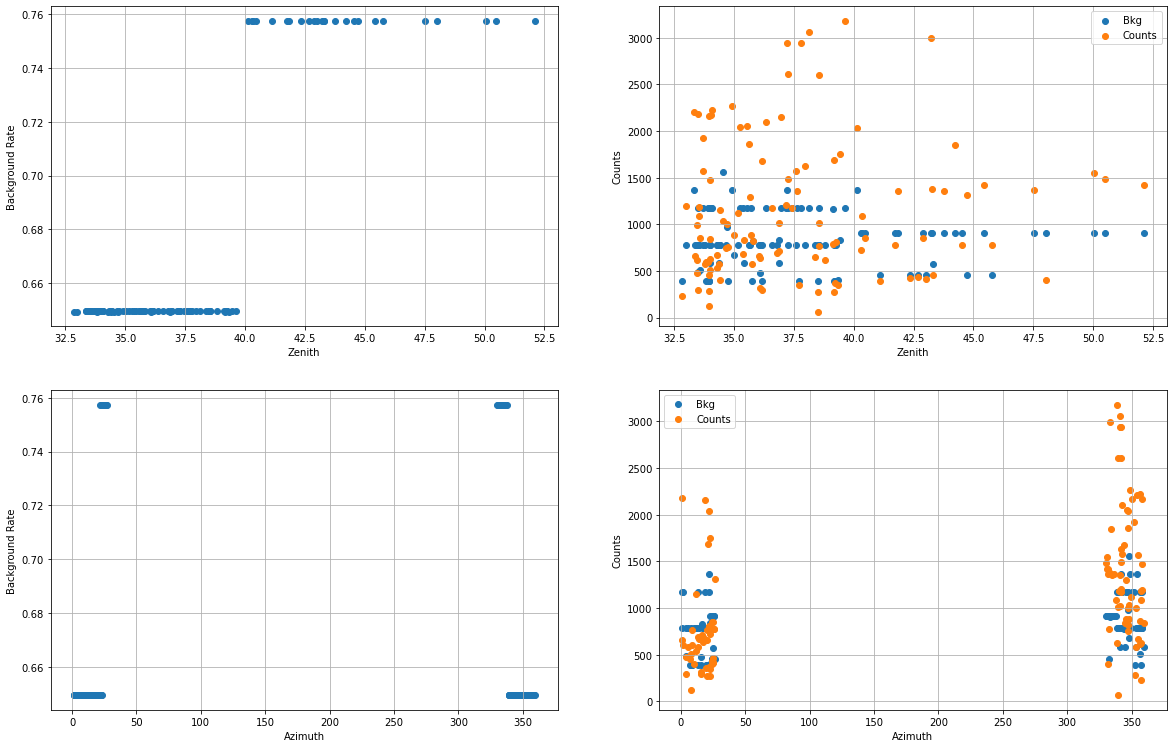

In [30]:
# Full Observations


a = list_of_datasets.info_table(cumulative=False)



zen_col = list(obs_table["ZEN_PNT"])
az_col = list(obs_table["AZ_PNT"])


from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
a["counts_rate"] = count_rate
a["excess_rate"] = excess_rate
a["background_rate"] = bkg_rate



fig = plt.figure(figsize = (20, 20))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()

a

In [15]:
# Models: Biggest Problem is that the model is the same for all dataset independent of the zenith angle

point_model = PointSpatialModel(lon_0="299.99916667 deg", lat_0="65.14861111 deg", evaluation_radius= "0.005 deg")
#point_model.parameters.free_parameters.freeze_all()
point_model.lat_0.frozen = True
point_model.lon_0.frozen = True
#point_model.lon_0.scale = 1.2
"""
gaussian_model = GaussianSpatialModel(lon_0="299.99916667 deg", lat_0="65.14861111 deg", sigma="0.07 deg",frame="icrs")
#gaussian_model.parameters.free_parameters.freeze_all()
gaussian_model.sigma.min = 0.1
"""
spatial_model = point_model


spectral_model = PowerLawSpectralModel(index=2.59, amplitude=3.2e-11 * u.Unit('1 / (cm2 s TeV)'), reference=1 * u.TeV)


model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    apply_irf={"exposure": True, "psf": True, "edisp": True},
)


for dataset in list_of_datasets:
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    bkg_model.spectral_model.norm.value = 1

models = Models([model, bkg_model])

# Joint Models
list_of_datasets.models = models.copy()

# Stacked Models
stacked.models = models.copy()

In [16]:
%%time
#Model Fitting
#Joint --> Not realistic to plot the Joint when you got so many runs
"""
fit_joint= Fit(list_of_datasets)
result_joint = fit_joint.run()
print(result_joint)
print(result_joint.parameters.to_table())
"""
# Stacked
fit_stacked= Fit(stacked)
result_stacked = fit_stacked.run()
print(result_stacked)
print(result_stacked.parameters.to_table())

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 65
	total stat : 261532.71

   name     value         unit         min        max    frozen   error  
--------- ---------- -------------- ---------- --------- ------ ---------
    index 3.3482e+00                       nan       nan  False 3.468e-02
amplitude 1.0234e-11 cm-2 s-1 TeV-1        nan       nan  False 2.848e-13
reference 1.0000e+00            TeV        nan       nan   True 0.000e+00
    lon_0 3.0000e+02            deg        nan       nan   True 0.000e+00
    lat_0 6.5149e+01            deg -9.000e+01 9.000e+01   True 0.000e+00
CPU times: user 1.33 s, sys: 245 ms, total: 1.58 s
Wall time: 1.81 s


In [17]:
# stacked.plot_residuals_spatial(vmin=-1, vmax=1);
# stacked.plot_residuals_spectral(region=region, method='diff/sqrt(model)')
"""
def plot_spectrum(model, result, label, color):
    spec = model.spectral_model
    energy_range = [0.2, 40] * u.TeV
    spec.plot(
        energy_range=energy_range, energy_power=2, label=label, color=color
    )
    spec.plot_error(energy_range=energy_range, energy_power=2, color=color)
plot_spectrum(stacked.models, result_stacked, label="stacked", color="tab:blue")
plot_spectrum(list_of_datasets.models, result_joint, label="joint", color="tab:orange")
plt.legend()
"""

'\ndef plot_spectrum(model, result, label, color):\n    spec = model.spectral_model\n    energy_range = [0.2, 40] * u.TeV\n    spec.plot(\n        energy_range=energy_range, energy_power=2, label=label, color=color\n    )\n    spec.plot_error(energy_range=energy_range, energy_power=2, color=color)\nplot_spectrum(stacked.models, result_stacked, label="stacked", color="tab:blue")\nplot_spectrum(list_of_datasets.models, result_joint, label="joint", color="tab:orange")\nplt.legend()\n'

In [31]:
# SKYMAP

estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.1, 1, 10] * u.TeV,
    apply_mask_fit=True
)
result = estimator.run(stacked)
print(result)

{'counts': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (350, 350, 2)
	ndim  : 3
	unit  : 
	dtype : float32
, 'background': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (350, 350, 2)
	ndim  : 3
	unit  : 
	dtype : float32
, 'excess': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (350, 350, 2)
	ndim  : 3
	unit  : 
	dtype : float32
, 'ts': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (350, 350, 2)
	ndim  : 3
	unit  : 
	dtype : float32
, 'sqrt_ts': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (350, 350, 2)
	ndim  : 3
	unit  : 
	dtype : float32
, 'err': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (350, 350, 2)
	ndim  : 3
	unit  : 
	dtype : float32
, 'flux': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (350, 350, 2)
	ndim  : 3
	unit  : 1 / (cm2 s)
	dtype : float64
}


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


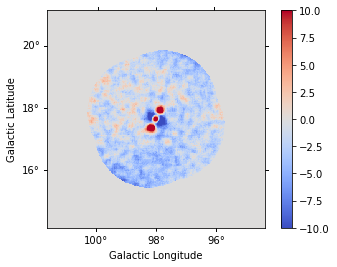

In [45]:

#counts : correlated counts map
#background : correlated background map
#excess : correlated excess map
#ts : TS map
#sqrt_ts : sqrt(delta TS), or Li-Ma significance map
#err : symmetric error map (from covariance)
#flux : flux map. An exposure map must be present in the dataset to compute flux map
#errn : negative error map
#errp : positive error map
#ul : upper limit map

result_d = result["sqrt_ts"].smooth(0 * u.deg).reduce(axis_name="energy")
result_d.plot(cmap="coolwarm", add_cbar=True, vmin=-10, vmax=10);

#result["background"].reduce(axis_name="energy").plot(cmap="coolwarm", add_cbar=True, vmin=-10, vmax=10)



In [20]:
a=[]
for i in range(0,250):
    a.append(result_d.interp_by_pix(pix=(125,i), fill_value=None))
b=[]
for i in range(0,250):
    b.append(result_d.interp_by_pix(pix=(i,125), fill_value=None))
#result_d.plot(slice={"lon_0":[83.5,83.7]})

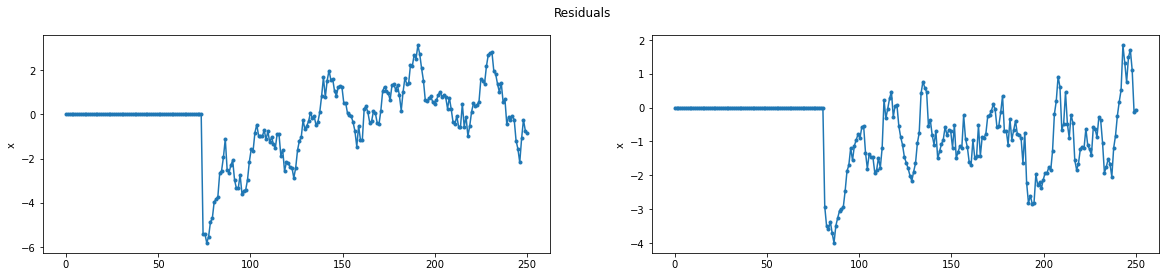

In [22]:
x1 = np.linspace(0.0, 250,250)

fig, (ax1,ax2) = plt.subplots(1, 2)
fig.suptitle('Residuals')
fig.set_figwidth(20)
ax1.plot(x1, a, 'o-',markersize=3)
ax1.set_ylabel('x')
ax2.plot(x1, b, 'o-',markersize=3)
ax2.set_ylabel('x')
plt.show()

In [23]:

e_edges = [ 0.39810717, 0.63095734,  1., 1.58489319,  2.51188643,  3.98107171, 6.30957344, 10., 15.84893192] * u.TeV
fpe = FluxPointsEstimator(energy_edges=e_edges)

"""
# Joint
flux_points = fpe.run(datasets=list_of_datasets)
flux_points_datasets = FluxPointsDataset(data=flux_points, models=list_of_datasets.models)
"""

# Stacked
flux_points = fpe.run(datasets=[stacked])
flux_points_stacked = FluxPointsDataset(data=flux_points, models=stacked.models)



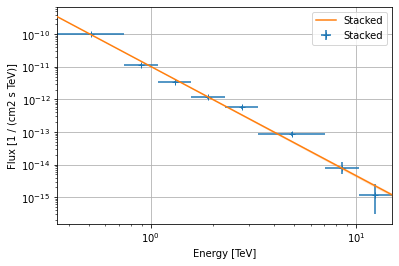

In [24]:
#Joint & Stacked
"""
fig, axs = plt.figure(figsize = (20, 20))
plt.subplot(2, 2, 1)
flux_points_datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Joint");
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
"""
flux_points_stacked.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Stacked");
plt.legend()
plt.grid()

time_min,time_max,counts [1],e_ref [1],e_min [1],e_max [1],ref_dnde [1],ref_flux [1],ref_eflux [1],ref_e2dnde [1],norm [1],stat [1],success [1],norm_err [1],ts [1],norm_errp [1],norm_errn [1],norm_ul [1],"norm_scan [1,11]","stat_scan [1,11]",sqrt_ts [1],dnde [1],dnde_ul [1],dnde_err [1],dnde_errp [1],dnde_errn [1],flux [1],flux_ul [1],flux_err [1],flux_errp [1],flux_errn [1]
,,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
54414.12966745328,54414.14358604182,1850.0,2.29128784747792,0.3499999999999999,15.0,3.737177112192202e-12,1.0655639448107978e-10,8.978725185443355e-11,1.9620179839009062e-11,1.0975693806249183,19822.45142456214,True,0.15622651705390908,92.73093995005183,0.160561807207804,0.1519377858939539,1.427570896881227,0.20000000000000004 .. 5.000000000000001,19873.813499682692 .. 20109.977677299987,9.629690542797928,4.101811168314416e-12,5.335085281856217e-12,5.838461638513738e-13,6.000479109892221e-13,5.678184159200438e-13,1.169530358922232e-10,1.521168076377849e-10,1.6646934379601474e-11,1.710888726742984e-11,1.618994265029799e-11
54417.06870762346,54417.08262638941,1628.0,2.29128784747792,0.3499999999999999,15.0,3.737177112192202e-12,1.0655639448107978e-10,8.978725185443355e-11,1.9620179839009062e-11,0.9086543799203355,16895.651814414334,True,0.11475427496736375,127.22947400951671,0.1178548415888999,0.11166948406969787,1.1505920874541224,0.20000000000000004 .. 5.000000000000001,16956.224480711706 .. 17382.901188254218,11.279604337454249,3.3958023515314755e-12,4.2999664147029955e-12,4.288570499342424e-13,4.404444165470744e-13,4.1732863999558666e-13,9.68229345537522e-11,1.2260294435757052e-10,1.222780179181271e-11,1.2558186991851985e-11,1.1899097596029381e-11
54420.06785549179,54420.08177221662,1013.0,2.29128784747792,0.3499999999999999,15.0,3.737177112192202e-12,1.0655639448107978e-10,8.978725185443355e-11,1.9620179839009062e-11,0.3209888281417079,11571.576073642545,True,0.0905743753400239,19.771165277265027,0.09459744839474432,0.08670096936580687,0.5187330829508499,0.20000000000000004 .. 5.000000000000001,11573.62837666529 .. 12197.568672994163,4.44647785075615,1.1995921018005871e-12,1.938597404940815e-12,3.3849248247184313e-13,3.5352741901262145e-13,3.2401687831877073e-13,3.4203412195487356e-11,5.5274327017297436e-11,9.651278868608971e-12,1.0079963028053963e-11,9.238542693634931e-12
54420.082682742286,54420.09660077975,1084.0,2.29128784747792,0.3499999999999999,15.0,3.737177112192202e-12,1.0655639448107978e-10,8.978725185443355e-11,1.9620179839009062e-11,0.3273590989119839,12499.758036712672,True,0.09117569312155323,19.443877137468007,0.09497016664915042,0.08727146268090748,0.5245918904468319,0.20000000000000004 .. 5.000000000000001,12501.966464194336 .. 13113.673615653963,4.409521191407068,1.2233989319217294e-12,1.9604928062195394e-12,3.407397135221287e-13,3.549203331422842e-13,3.2614891287862335e-13,3.488220528063617e-11,5.5898620420028e-11,9.715353123346098e-12,1.011967854140076e-11,9.29933240436761e-12
54421.09222567843,54421.10614294161,1362.0,2.29128784747792,0.3499999999999999,15.0,3.737177112192202e-12,1.0655639448107978e-10,8.978725185443355e-11,1.9620179839009062e-11,0.6892592371004866,14865.53910631952,True,0.12304251210757866,57.509737597065396,0.1270571690781056,0.11902766138832661,0.9514124365980908,0.20000000000000004 .. 5.000000000000001,14887.713835591088 .. 15297.726069992945,7.583517495006219,2.5758838452589973e-12,3.5555967823093997e-12,4.598316600750749e-13,4.748351442186311e-13,4.4482745185821775e-13,7.344497916820756e-11,1.0137907890835147e-10,1.3110966458078187e-11,1.35387538299358

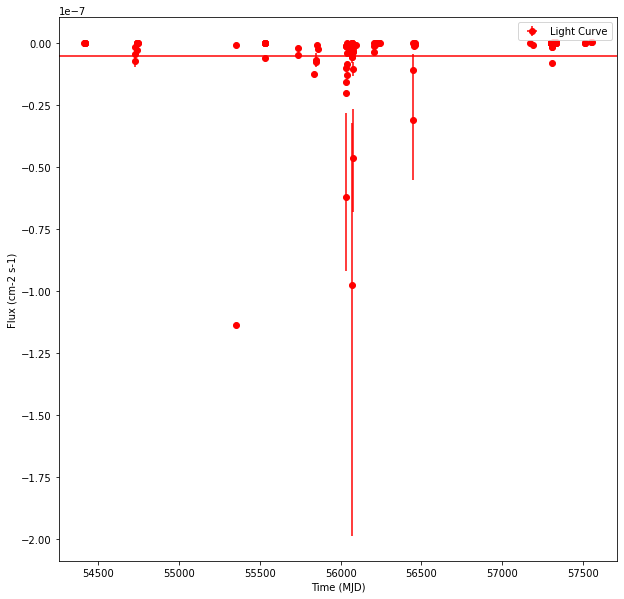

In [25]:
lc_maker_1d = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], reoptimize=True)
lc_complete = lc_maker_1d.run(list_of_datasets)

plt.figure(figsize=(10,10))
ax = lc_complete.plot(marker="o", color="red", label=f"Light Curve")
plt.axhline(y=lc_complete.table["flux"].mean(), color="red", label="Mean Flux Line Gam")

lc_complete.table



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()
No handles with labels found to put in legend.


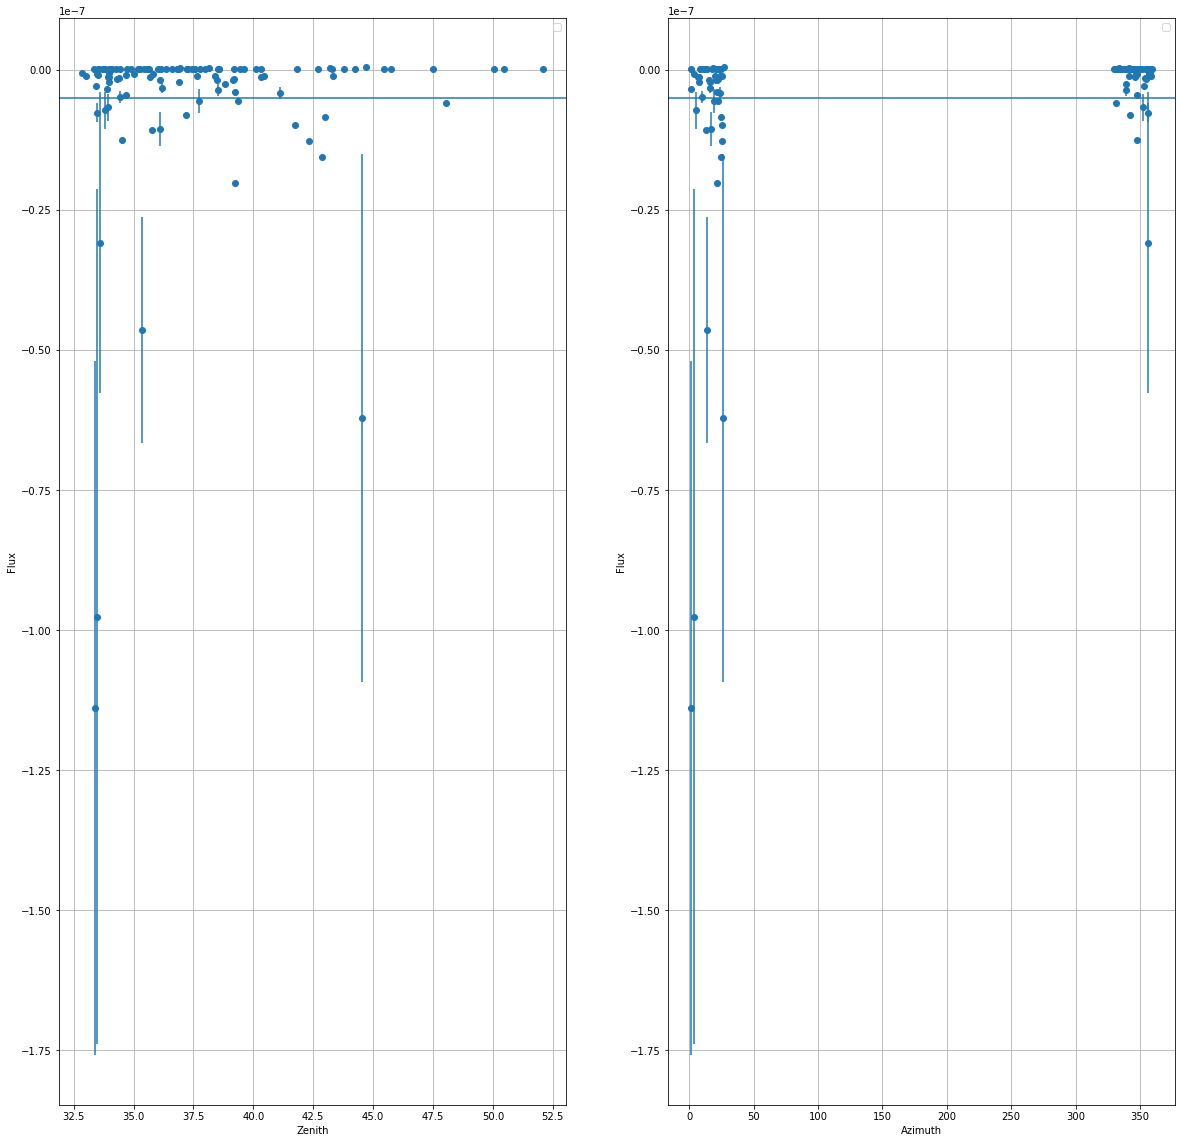

In [26]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2,1)
plt.errorbar(x=list(obs_table["ZEN_PNT"]),y=list(lc_complete.table["flux"]), yerr=list(lc_complete.table["flux_err"]), fmt="o")
plt.axhline(y=lc_complete.table["flux"].mean(), color="tab:blue")
plt.xlabel("Zenith")
plt.ylabel("Flux")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.errorbar(x=list(obs_table["AZ_PNT"]),y=list(lc_complete.table["flux"]), yerr=list(lc_complete.table["flux_err"]), fmt="o")
plt.axhline(y=lc_complete.table["flux"].mean(), color="tab:blue")
plt.xlabel("Azimuth")
plt.ylabel("Flux")
plt.legend()
plt.grid()

In [27]:
list_spectrum_datasets = Datasets()

joint_stacked = SpectrumDataset.create(e_reco=energy_axis, e_true=energy_axis_true, region=on_region, name="Spectrum_stacked from Joint")

for dataset in list_of_datasets:
    spectrum_dataset = dataset.to_spectrum_dataset(on_region=on_region, containment_correction=True, name = dataset.name)
    joint_stacked.stack(spectrum_dataset)
    list_spectrum_datasets.append(spectrum_dataset)
    
stack_stacked = stacked.to_spectrum_dataset(on_region=on_region, containment_correction=True, name = "Spectrum_stacked from Stack")



In [33]:
print("STACKED STACK")
print(stack_stacked)
print(stack_stacked.info_dict())
print()
print("JOINT_STACKED")
print(joint_stacked)
print(joint_stacked.info_dict())

STACKED STACK
SpectrumDataset
---------------

  Name                            : Spectrum_stacked from Stack 

  Total counts                    : 1901 
  Total background counts         : 364.39
  Total excess counts             : 1536.61

  Predicted counts                : 364.39
  Predicted background counts     : 364.39
  Predicted excess counts         : nan

  Exposure min                    : 7.61e+06 m2 s
  Exposure max                    : 3.02e+10 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


{'name': 'Spectrum_stacked from Stack', 'counts': 1901.0, 'background': 364.3892, 'excess': 1536.6108, 'sqrt_ts': 56.63346812217333, 'npred': 364.38921505212784, 'npred_background': 364.3892, 'npred_signal': nan, 'exposure_min': <Quantity 7606653. m